In [80]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.distributed as dist


In [81]:
from nets.SegRank import SegRank
from data import PlacePulseDataset, AdaptTransform
from train_scripts.SegRank import train
import seg_transforms

In [82]:
## Constants
PLACE_PULSE_PATH ='votes'
IMAGES_PATH= 'pp_cropped/'
MODEL_PATH = 'models/segrank_resnet_wealthy_15_model_33.pth'
IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
ATTRIBUTE='wealthy_orig'
BATCH_SIZE = 1
CS_CLASSES = [
    'road',
    'sidewalk',
    'building',
    'wall',
    'fence',
    'pole',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'train',
    'motorcycle',
    'bicycle'
]
N_LAYERS=1
N_HEADS=1
SOFTMAX=True

## Setup Network

In [83]:
transformers = transforms.Compose([
        AdaptTransform(seg_transforms.ToArray()),
        AdaptTransform(seg_transforms.SubstractMean(IMG_MEAN)),
        AdaptTransform(seg_transforms.Resize((244,244))),
        AdaptTransform(seg_transforms.ToTorchDims())
        ])

dataset=PlacePulseDataset(
    f'{PLACE_PULSE_PATH}/{ATTRIBUTE}/val.csv',
    IMAGES_PATH,
    transform=transformers,
    return_images=True
    )

loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=1, drop_last=True)

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dist.init_process_group('gloo', init_method='file:///tmp/tmpfile', rank=0, world_size=1)

RuntimeError: trying to initialize the default process group twice!

In [85]:
net = SegRank(image_size=(244,244), n_layers=N_LAYERS, n_heads=N_HEADS, softmax=SOFTMAX)
net.load_state_dict(torch.load(MODEL_PATH, map_location=device))
net.eval()
print('loaded')

loaded


## Forward Pass

In [86]:
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
label

tensor([-1])

In [87]:
torch.set_printoptions(precision=15)

with torch.no_grad():
    forward_dict = net(input_left,input_right)
    output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']
output_rank_left, output_rank_right

(tensor([[-2.952406406402588]]), tensor([[-2.983307123184204]]))

## Image visualization

In [88]:
from PIL import Image as PILImage
from torch import nn
import cv2

def segmentation_to_image(segmentation,image,palette, output_size=(244, 244)):
    grayed = gray_image(image,output_size)
    interp = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
    segmentation = interp(segmentation.unsqueeze(0)).cpu().numpy().transpose(0,2,3,1)
    seg_pred = np.asarray(np.argmax(segmentation, axis=3), dtype=np.uint8)
    output_im = PILImage.fromarray(seg_pred[0])
    output_im.putpalette(palette)
    output_im = output_im.convert('RGB')
    result = cv2.addWeighted(np.array(output_im), 0.7, grayed, 0.3, 0)
    return result

def attention_to_images(image,attention_map,output_size=(244,244), normalize='local'):
    cvImage = gray_image(image,output_size)
    attention_map = attention_map[:,:,0:960]
    interp = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
    attention_map = attention_map.mean(dim=2, keepdim=True)
    attention_size = attention_map.size()
    dim = int(attention_size[1]**(0.5))
    attention_map = attention_map.permute([0,2,1]).view((attention_size[0],1,dim,dim))
    attention_map = interp(attention_map).squeeze(1).cpu().detach().numpy()
    
    return global_normalize(cvImage, attention_map) if normalize == 'global' else local_normalize(cvImage, attention_map)


def gray_image(image,output_size):
    cvImage = cv2.cvtColor(image.cpu().numpy(), cv2.COLOR_RGB2BGR)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_BGR2GRAY)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_GRAY2BGR) #we neeed a 3 dimensional gray image
    cvImage = cv2.resize(cvImage, output_size)
    return cvImage

def global_normalize(image,attention_map):
    images = []
    heatmap_img = None
    heatmap_img = cv2.normalize(attention_map, heatmap_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    for single_map in heatmap_img:
        single_img = cv2.applyColorMap(single_map, cv2.COLORMAP_JET)
        result = cv2.addWeighted(single_img, 0.5, image, 0.5, 0)
        result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
        images.append(result)
    return images

def local_normalize(image,attention_map):
    images = []
    for single_map in attention_map:
        heatmap_img = None
        heatmap_img = cv2.normalize(single_map, heatmap_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
        result = cv2.addWeighted(img, 0.5, image, 0.5, 0)
        result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
        images.append(result)
    return images


def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """

    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

def image_log(segmentation,original,attention_map,palette, normalize='local'):
    seg_img = segmentation_to_image(segmentation, original, palette)
    attentions = attention_to_images(original, attention_map, normalize=normalize)
    return seg_img, attentions

def show_layout(images, titles=None):
    aux_titles = titles if titles is not None else {}
    fig = plt.figure(figsize=(25, 50))
    for i in range(len(images)):
        sub = fig.add_subplot(11, 4, i + 1)
        if i < len(aux_titles):
            sub.set_title(titles[i])
        sub.imshow(images[i], interpolation='nearest')

In [89]:
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
with torch.no_grad():
    forward_dict = net(input_left,input_right)
    output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']

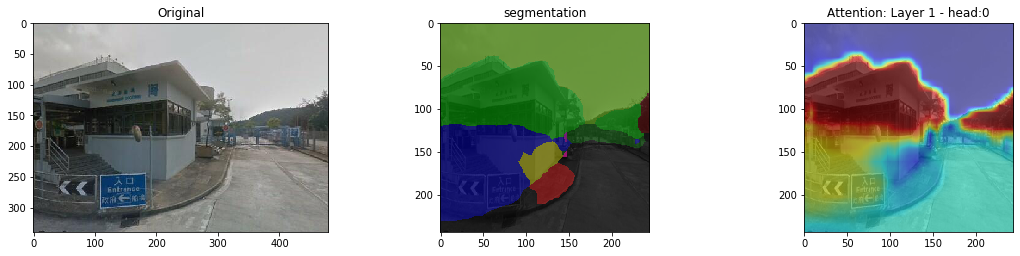

In [90]:
torch.set_printoptions(precision=10)

segmentation = forward_dict['left']['segmentation'][0]
original = left_original[0]
normalize='local'
titles = {
    0: 'Original',
    1: 'segmentation'
}
seg_classes = np.argmax(segmentation, axis=0)
if N_LAYERS==2:    
    attention_map, attention_map_2 = forward_dict['left']['attention'][0][0], forward_dict['left']['attention'][1][0]
    seg_img, attentions = image_log(segmentation,original,attention_map,get_palette(19), normalize)
    _, attentions_2 = image_log(segmentation,original,attention_map_2,get_palette(19), normalize)
    final_attn = []
    for i in range(len(attentions)):
        final_attn += [attentions[i], attentions_2[i]]
        titles[2*i + 2] = f'Attention: Layer 1 - head:{i}'
        titles[2*i + 3] = f'Attention: Layer 2 - head:{i}'
else:
    attention_map = forward_dict['left']['attention'][0][0]
    seg_img, attentions = image_log(segmentation,original,attention_map,get_palette(19), normalize)
    final_attn = attentions
    for i in range(len(attentions)):
        titles[i+ 2] = f'Attention: Layer 1 - head:{i}'
show_layout([original,seg_img] + final_attn, titles)

## Averaged attentions

In [91]:
def avg_attn(original,attention_map):
    interp = nn.Upsample(size=(244,244), mode='bilinear', align_corners=True)
    attention_map = attention_map[:,:,0:960]
    attention_size = attention_map.size()
    dim = int(attention_size[1]**(0.5))
    attention_mean = attention_map.mean(dim=2,keepdim=True)
    attention_mean = attention_mean.view((attention_size[0],1,dim,dim))
    final_mean = interp(attention_mean).squeeze(1).numpy()
    final_mean = np.mean(final_mean, axis=0)
    heatmap_img = None
    heatmap_img = cv2.normalize(final_mean, heatmap_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
    cvImage = cv2.cvtColor(original.cpu().numpy(), cv2.COLOR_RGB2BGR)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_BGR2GRAY)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_GRAY2BGR) #we neeed a 3 dimensional gray image
    cvImage = cv2.resize(cvImage, (244,244))
    result = cv2.addWeighted(img, 0.5, cvImage, 0.5, 0)
    result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
    return result, final_mean


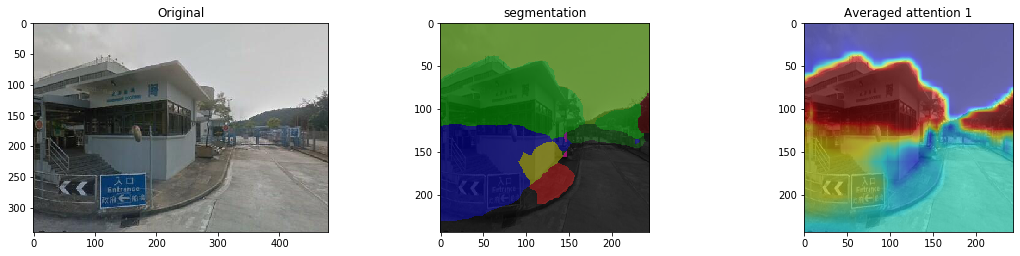

In [92]:
segmentation = forward_dict['left']['segmentation'][0]
original = left_original[0]
normalize='local'
if N_LAYERS == 2:
    attention_map, attention_map_2 = forward_dict['left']['attention'][0][0], forward_dict['left']['attention'][1][0]
    seg_img, _ = image_log(segmentation,original,attention_map,get_palette(19), normalize)

    avg_1, attentions_1 = avg_attn(original,attention_map)
    avg_2, attentions_2 = avg_attn(original,attention_map_2)
    titles = {
        0: 'Original',
        1: 'segmentation',
        2: 'Averaged attention 1',
        3: 'Averaged attention 2',
    } 
    show_layout([original,seg_img, avg_1, avg_2], titles)
else:
    attention_map = forward_dict['left']['attention'][0][0]
    seg_img, _ = image_log(segmentation,original,attention_map,get_palette(19), normalize)
    avg_1, _ = avg_attn(original,attention_map)
    titles = {
        0: 'Original',
        1: 'segmentation',
        2: 'Averaged attention 1',
    } 
    show_layout([original,seg_img, avg_1], titles)

## Attention Distribution

In [93]:
import seaborn as sns

sns.distplot(attentions_1.flatten(), label="First layer average weights")

NameError: name 'attentions_1' is not defined

In [ ]:
sns.distplot(attentions_2.flatten(), label="Second layer average weights")

## MHA weights

El producto entre las 19 cabezas de atención y los pesos finales se hace mediante una capa Lineal, o sea el calculo es xAt, donde x es la atención y A los pesos.
Por lo tanto cada fila de la traspuesta pondera a una cabeza o atributo. El peso de cada cabeza se podría tomar como el promedio de cada fila de pesos.

### Out projection weights

In [ ]:
mha_weights = net.attentions[0].out_proj.weight.t().norm(dim=0).detach().numpy() #los pesos se usan traspuestos
sns.scatterplot(y=mha_weights, x=range(19)) 

In [ ]:
np.array(CS_CLASSES)[np.flip(np.argsort(mha_weights))]

### In projection weights

In [ ]:
weights_q,weights_k,weights_v = [x.norm(dim=0).detach().numpy() for x in  net.attentions[0].in_proj_weight.t().chunk(3, dim=-1)]
sns.scatterplot(y=weights_q, x=range(19)) 
sns.scatterplot(y=weights_k, x=range(19)) 
sns.scatterplot(y=weights_v, x=range(19)) 

In [ ]:
np.array(CS_CLASSES)[np.flip(np.argsort(mha_weights))]

## Visualize attributes

In [94]:
MODELS = {
    'wealthy':'models/segrank_resnet_wealthy_15_model_33.pth',
    'depressing': 'models/segrank_resnet_depressing_15_model_5.pth',
    'safety': 'models/segrank_resnet_safety_15_model_34.pth',
    'boring': 'models/segrank_resnet_boring_15_model_14.pth',
    'lively': 'models/segrank_resnet_lively_15_model_20.pth',
    'beautiful':'models/segrank_resnet_beautiful_15_model_9.pth',
}

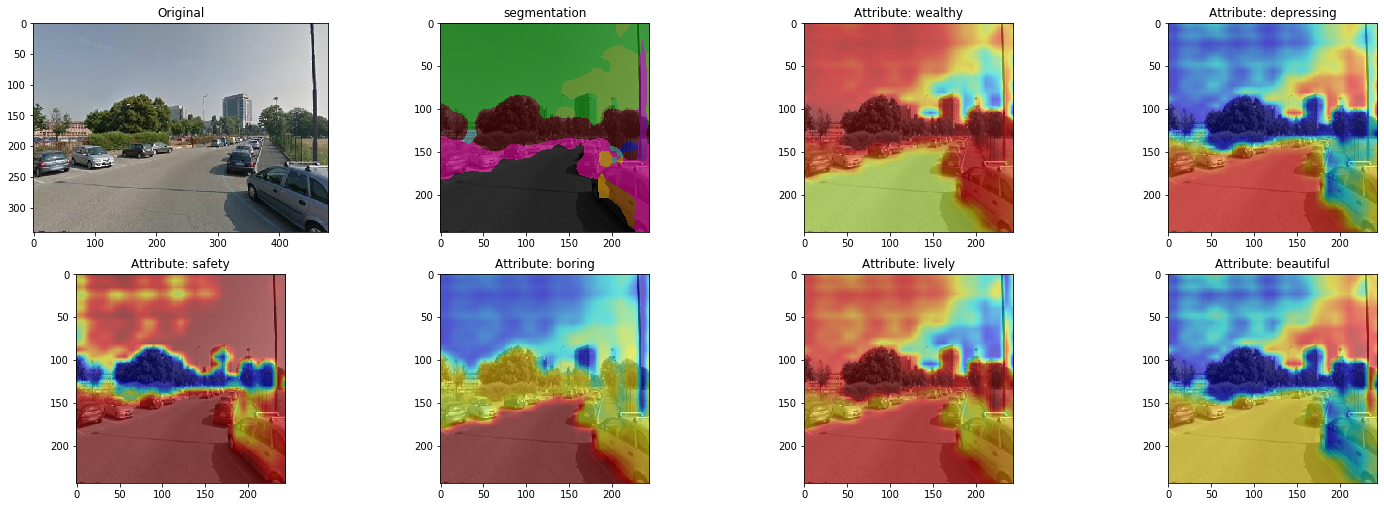

In [97]:
torch.set_printoptions(precision=10)
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
original = left_original[0]
titles = ['Original', 'segmentation']
total_attentions = []
normalize='local'
for attribute, path in MODELS.items():
    net = SegRank(image_size=(244,244), n_layers=N_LAYERS, n_heads=N_HEADS, softmax=SOFTMAX)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    with torch.no_grad():
        forward_dict = net(input_left,input_right)
        output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']
    
    segmentation = forward_dict['left']['segmentation'][0]
    seg_classes = np.argmax(segmentation, axis=0)
    if N_LAYERS == 2:
        attention_map, attention_map_2 = forward_dict['left']['attention'][0][0], forward_dict['left']['attention'][1][0]
        seg_img, attentions = image_log(segmentation,original,attention_map,get_palette(19), normalize)
        _, attentions_2 = image_log(segmentation,original,attention_map_2,get_palette(19), normalize)
        for i in range(len(attentions)):
            total_attentions += [attentions[i], attentions_2[i]]
            titles.append(f'Attribute: {attribute} - Layer 1')
            titles.append(f'Attribute: {attribute} - Layer 2')
    else:
        attention_map = forward_dict['left']['attention'][0][0]
        seg_img, attentions = image_log(segmentation,original,attention_map,get_palette(19), normalize)
        total_attentions += attentions
        for i in range(len(attentions)):
            titles.append(f'Attribute: {attribute}')

show_layout([original,seg_img] + total_attentions, titles)